In [137]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import yaml
from prithvi.Prithvi import MaskedAutoencoderViT
from PIL import Image
import time

NO_DATA = -9999
NO_DATA_FLOAT = 0.0001
PERCENTILES = (0.1, 99.9)

In [5]:
# load weights
weights_path = "./prithvi/Prithvi_100M.pt"
checkpoint = torch.load(weights_path, map_location="cpu")

# read model config
model_cfg_path = "./prithvi/Prithvi_100M_config.yaml"
with open(model_cfg_path) as f:
    model_config = yaml.safe_load(f)

model_args, train_args = model_config["model_args"], model_config["train_params"]
# let us use only 1 frame for now (the model was trained on 3 frames)
model_args["num_frames"] = 1
means_list = train_args["data_mean"]
std_list = train_args["data_std"]

means = np.array(means_list).reshape(-1, 1, 1)
stds = np.array(std_list).reshape(-1, 1, 1)

# instantiate model
model = MaskedAutoencoderViT(**model_args)
model.eval()

# load weights into model
# strict=false since we are loading with only 1 frame, but the warning is expected
del checkpoint['pos_embed']
del checkpoint['decoder_pos_embed']
_ = model.load_state_dict(checkpoint, strict=False)

In [13]:
def load_raster(path, crop=None):
    with rasterio.open(path) as src:
        img = src.read()
        img = img[:6]
        img = np.where(img == NO_DATA, NO_DATA_FLOAT, img)
        if crop:
            img = img[:, -crop[0]:, -crop[1]:]
    return img

def enhance_raster_for_visualization(raster, ref_img=None):
    if ref_img is None:
        ref_img = raster
    channels = []
    for channel in range(raster.shape[0]):
        valid_mask = np.ones_like(ref_img[channel], dtype=bool)
        valid_mask[ref_img[channel] == NO_DATA_FLOAT] = False
        mins, maxs = np.percentile(ref_img[channel][valid_mask], PERCENTILES)
        normalized_raster = (raster[channel] - mins) / (maxs - mins)
        normalized_raster[~valid_mask] = 0
        clipped = np.clip(normalized_raster, 0, 1)
        channels.append(clipped)
    clipped = np.stack(channels)
    channels_last = np.moveaxis(clipped, 0, -1)[..., :3]
    rgb = channels_last[..., ::-1]
    return rgb

In [14]:
def load_image_geotiff(path):
    loaded = load_raster(path, crop=(224, 224))
    return (loaded[0:3],loaded)

def load_image_jpg(path):
    image_file = Image.open(path)
    image_file.load()
    loaded_image = np.asarray( image_file, dtype="uint16" )
    crop=(224, 224)
    loaded_image = loaded_image.transpose(2,0,1)
    loaded_image = loaded_image[:, -crop[0]:, -crop[1]:]

    loaded_image[0,:]  = loaded_image[0,:] * ((means_list[0] + std_list[0] * 2) / 255)
    loaded_image[1,:]  = loaded_image[1,:] * ((means_list[1] + std_list[1] * 2) / 255)
    loaded_image[2,:]  = loaded_image[2,:] * ((means_list[2] + std_list[2] * 2) / 255)
    return (loaded_image, None)


In [120]:
def normalize(img,channels,duplicate = False):
    normalized = img.copy()
    normalized = ((img - means[0:channels]) / stds[0:channels])
    if duplicate:
        normalized = np.concatenate((normalized,normalized))
    normalized = torch.from_numpy(normalized.reshape(1, normalized.shape[0], 1, *normalized.shape[-2:])).to(torch.float32)
    return normalized

def process_image(input_image_tup):
    rgb,full = input_image_tup

    to_evaluate = [rgb]
    
    # 1. Fill in with normalized original image
    to_evaluate.append(normalize(rgb, 3,duplicate=True))

    # 2. Fill in with original image
    dup_filled = np.concatenate((rgb,rgb))
    to_evaluate.append(normalize(dup_filled, 6))

    # 3. Fill in with means (so zeros after standardization)
    mean_tensor = (np.ones([3, *rgb.shape[1:]]) * np.array(means_list)[len(rgb):, None, None])
    mean_filled = np.concatenate((rgb,mean_tensor))
    to_evaluate.append(normalize(mean_filled, 6))
    
    # 4. Use actual infrared bands if you have them
    if full is not None:
        to_evaluate.append(normalize(full,6))
    return tuple(to_evaluate)

In [164]:
def calc_loss_rgb(pred_img, original):
    err = torch.sum((pred_img[:,0:3,:,:,:] - original) ** 2)
    err /= (224 * 224)
    return err
# Input: list of tuples(3-4) of images
def evaluate_images(image_tuple_lists,mask_ratio):

    results = []
    for img_n, img in enumerate(image_tuple_lists):
        
        with torch.no_grad():
            original = img[0]
            normalized_rgb = normalize(original,3)
            
            loss1, pred1, mask,noise = model(img[1], mask_ratio=mask_ratio)
            mask_img = model.unpatchify(mask.unsqueeze(-1).repeat(1, 1, pred1.shape[-1])).detach().cpu()
            pred1_img = model.unpatchify(pred1).detach().cpu()
            loc_results = [mask_img,original,img[1],(loss1,pred1_img,calc_loss_rgb(pred1_img,normalized_rgb))]
            for i in range(2,len(img)):
                loss_i, pred_i = model(img[i], mask_ratio=mask_ratio, mask_noise=noise)[0:2]
                pred_i_img = model.unpatchify(pred_i).detach().cpu()
                loc_results.append((loss_i,pred_i_img,calc_loss_rgb(pred_i_img,normalized_rgb))) # HAVE TO EDIT Prithvi.py model code give a custom mask
            results.append(tuple(loc_results))

    return results
titles = ["Post-norm duplicated", "Pre-norm duplicated", "Means","Original (all 6)"]
def plot_image_mask_reconstruction(result, subfigure,path):
    mask, original_img, normalized, loss_preds = result[0],result[1],result[2],result[3:]

    # Mix visible and predicted patches
    mask_img_np = mask.numpy().reshape(6, 224, 224).transpose((1, 2, 0))[..., :3]
    ax = subfigure.subplots(2, 3)
    subfigure.suptitle(f"Results for "+path.split("/")[-1],wrap = True)
    for row in ax:
        for subplot in row:
            subplot.axis('off')

    ax[0,0].imshow(enhance_raster_for_visualization(original_img))
    ax[0,0].set_title("Base image:")

    masked_img_np = enhance_raster_for_visualization(original_img).copy()
    masked_img_np[mask_img_np[..., 0] == 1] = 0
    ax[0,1].imshow(masked_img_np)
    ax[0,1].set_title("Masked image:")

    for i in range(0,len(loss_preds)):
        loss,pred,loss_rgb = loss_preds[i]
        rec_img = normalized.clone()
        rec_img[mask == 1] = pred[mask == 1]  # binary mask: 0 is keep, 1 is remove
        rec_img_np = (rec_img.numpy().reshape(6, 224, 224) * stds) + means
        row = 1
        title = titles[i]
        if i == 3:
            i = 2
            row = 0
        if len(original_img) == 3:
            ax[row,i].imshow(enhance_raster_for_visualization(rec_img_np, ref_img=np.concatenate((original_img,original_img))))
        else:
            ax[row,i].imshow(enhance_raster_for_visualization(rec_img_np, ref_img=original_img))
        ax[row,i].set_title(f"{title}:\nModel-given loss: {loss.item():.4f}\nRGB loss: {loss_rgb.item():.4f}")


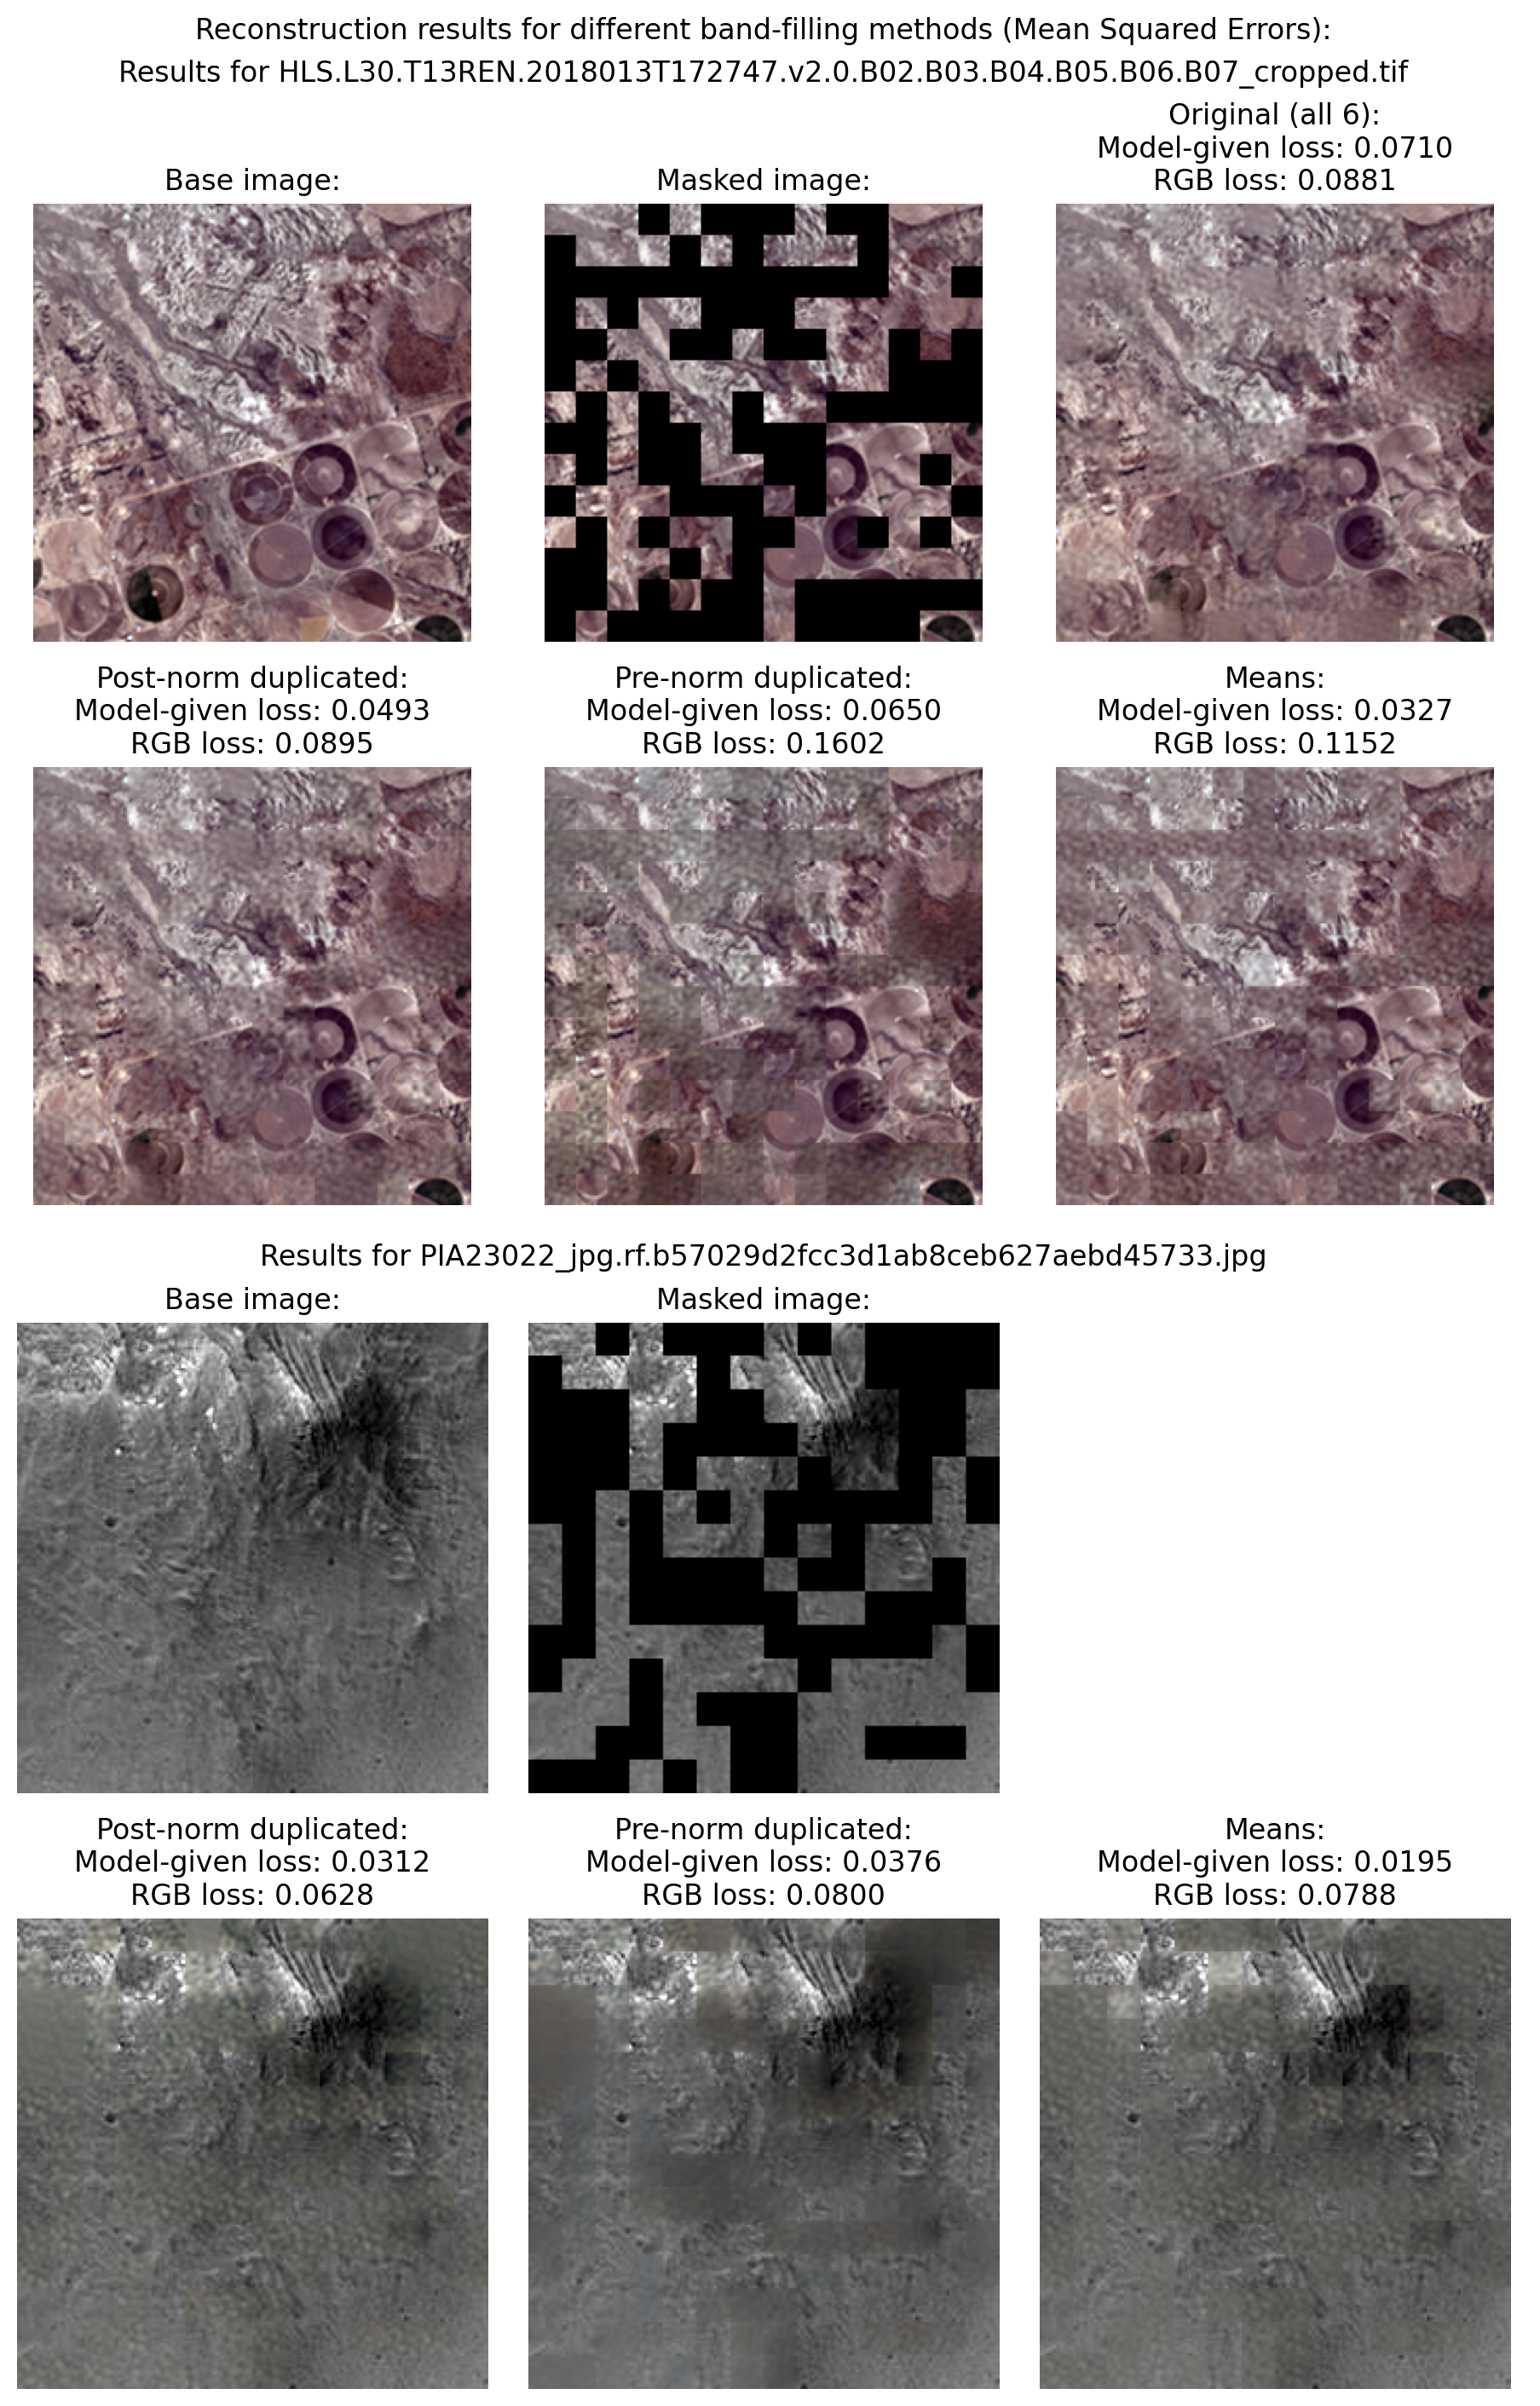

In [165]:
file_paths = ["https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-demo/resolve/main/HLS.L30.T13REN.2018013T172747.v2.0.B02.B03.B04.B05.B06.B07_cropped.tif","PIA23022_jpg.rf.b57029d2fcc3d1ab8ceb627aebd45733.jpg"]
MASK_RATIO = 0.5

to_evaluate = []
for path in file_paths:
    if ".tif" in path:
        loaded = load_image_geotiff(path)
    else:
        loaded = load_image_jpg(path)

    # append tuple of 3-4 normalized inputs to the list
    to_evaluate.append(process_image(loaded))
results = evaluate_images(to_evaluate, MASK_RATIO)

fig = plt.figure(constrained_layout=True)
fig.suptitle('Reconstruction results for different band-filling methods (Mean Squared Errors):')
fig.set_size_inches(9, 14)
fig.set_dpi(200)
subfigs = fig.subfigures(nrows=len(results), ncols=1) #https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot

for result_object in zip(results,subfigs,file_paths):
    plot_image_mask_reconstruction(result_object[0],result_object[1],result_object[2])
    
fig.savefig(os.path.join("reconstruct_output",f"mse_{time.time()}.png"))